## Лабораторная работа № 1
### Разведочный анализ данных с помощью PySpark
#### Цель и задачи работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием `pyspark`.
### Выполните разведочный анализ выбранного датасета с определением: 
* типов признаков в датасете; 
* пропущенных значений и их устранением; 
* выбросов и их устранением; 
* расчетом статистических показателей признаков (средних, квартилей и т.д.); 
* визуализацией распределения наиболее важных признаков; 
* корреляций между признаками.

## Ход работы

#### Создание сессии и загрузка датасета

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *  # col, to_date, udf, count
from pyspark.sql.types import StringType, BooleanType, DateType, IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pandas import DataFrame

import matplotlib

import os
import sys
import re

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('SOBDLab1') \
    .getOrCreate()
csv_file = 'data/itineraries.csv'
data = spark.read.csv(csv_file, header=True)
data = data.drop('legId', 'segmentsDepartureTimeEpochSeconds',
                 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds',
                 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode',
                 'segmentsDepartureAirportCode', 'segmentsAirlineName',
                 'segmentsAirlineCode', 'segmentsEquipmentDescription',
                 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode')


#### Определение типов признаков

In [2]:
data.printSchema()
data.first()

root
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: string (nullable = true)



Row(searchDate='2022-04-16', flightDate='2022-04-17', startingAirport='ATL', destinationAirport='BOS', fareBasisCode='LA0NX0MC', travelDuration='PT2H29M', elapsedDays='0', isBasicEconomy='False', isRefundable='False', isNonStop='True', baseFare='217.67', totalFare='248.60', seatsRemaining='9', totalTravelDistance='947')

#### Устранение пропущенных значений и сокращение размера

In [3]:
#print(data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show())
data = data.dropna()

In [4]:
data1 = data.sample(fraction=0.05)#0,05
data = data1

#### Преобразование типов

In [5]:
data = data.withColumn('searchDate', to_date(data.searchDate, 'yyyy-mm-dd'))
data = data.withColumn('flightDate', to_date(data.flightDate, 'yyyy-mm-dd'))


def travelDurationtoInt(travelDuration: str) -> int:
    periods = re.findall(r'\d{1,2}', travelDuration)
    intDuration = 0
    if len(periods) > 0:
        intDuration = int(periods[0]) * 60
    if len(periods) > 1:
        intDuration += int(periods[1])
    return intDuration


duration_cast = udf(lambda x: travelDurationtoInt(x), IntegerType())
data = data.withColumn('travelDuration', duration_cast('travelDuration'))

data = data.withColumn('elapsedDays', data.elapsedDays.cast(IntegerType()))
data = data.withColumn('isBasicEconomy', data.isBasicEconomy.cast(BooleanType()))
data = data.withColumn('isRefundable', data.isRefundable.cast(BooleanType()))
data = data.withColumn('isNonStop', data.isNonStop.cast(BooleanType()))
data = data.withColumn('baseFare', data.baseFare.cast(DoubleType()))
data = data.withColumn('totalFare', data.totalFare.cast(DoubleType()))
data = data.withColumn('seatsRemaining', data.seatsRemaining.cast(IntegerType()))
data = data.withColumn('totalTravelDistance', data.totalTravelDistance.cast(IntegerType()))

data.printSchema()
data.show()


root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)

+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|tota

#### Кодирование категориальных признаков

In [6]:
indexer = StringIndexer(inputCols=["startingAirport", "destinationAirport"],
                        outputCols=["startingAirport_indexed", "destinationAirport_indexed"],
                        stringOrderType='alphabetAsc')
indexerModel = indexer.fit(data)
data = indexerModel.transform(data)

indexer = StringIndexer(inputCols=["fareBasisCode"],
                        outputCols=["fareBasisCode_indexed"],
                        stringOrderType='alphabetAsc')
indexerModel = indexer.fit(data)
data = indexerModel.transform(data)

data = data.withColumn('startingAirport', data.startingAirport_indexed.cast(IntegerType()))
data = data.withColumn('destinationAirport', data.destinationAirport_indexed.cast(IntegerType()))
data = data.withColumn('fareBasisCode', data.fareBasisCode_indexed.cast(IntegerType()))

data = data.drop('startingAirport_indexed', 'destinationAirport_indexed', 'fareBasisCode_indexed')
data.show()


+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|2022-01-16|2022-01-17|              0|                 1|         1706|           155|          0|         false|       false|     true|  357.21|    398.6|             2|                947|
|2022-01-16|2022-01-17|              0|                 1|         1706|           158|          0|         false|       false|     true|  357.21|    398.6|             9|                947|
|2022-01-16|2022-01-17|              0| 

In [7]:
df = data.toPandas()
df.to_csv('data/proceed.csv')

#### Устранение выбросов

In [8]:
data1 = data
columns = ['travelDuration', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
for column in columns:
    q1, q2, q3 = data.approxQuantile(column, [0.25, 0.5, 0.75], 0)
    print(f'{column}: firstquartile = {q1} median = {q2} lastquartile = {q3}')
    IQR = q3 - q1
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)
    data1 = data1.filter(data1[column] > lower_bound)
    data1 = data1.filter(data1[column] < upper_bound)

data1.show()


travelDuration: firstquartile = 255.0 median = 399.0 lastquartile = 553.0
baseFare: firstquartile = 171.16 median = 273.49 lastquartile = 407.44
totalFare: firstquartile = 202.6 median = 313.2 lastquartile = 461.6
seatsRemaining: firstquartile = 5.0 median = 7.0 lastquartile = 9.0
totalTravelDistance: firstquartile = 876.0 median = 1467.0 lastquartile = 2415.0
+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|2022-01-16|2022-01-17|              0|                 1|   

In [9]:
data_count = data.count()
data1_count = data1.count()
print(data1_count/data_count)

0.9750623605300961


In [10]:
print(data_count)

3803688


In [11]:
df = data1.toPandas()
df.to_csv('data/cleared.csv')

#### Визуализация распределения наиболее важных признаков

array([[<Axes: title={'center': 'travelDuration'}>,
        <Axes: title={'center': 'baseFare'}>],
       [<Axes: title={'center': 'totalFare'}>,
        <Axes: title={'center': 'seatsRemaining'}>],
       [<Axes: title={'center': 'totalTravelDistance'}>, <Axes: >]],
      dtype=object)

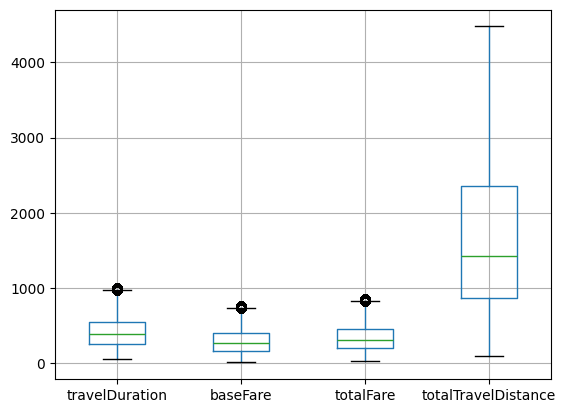

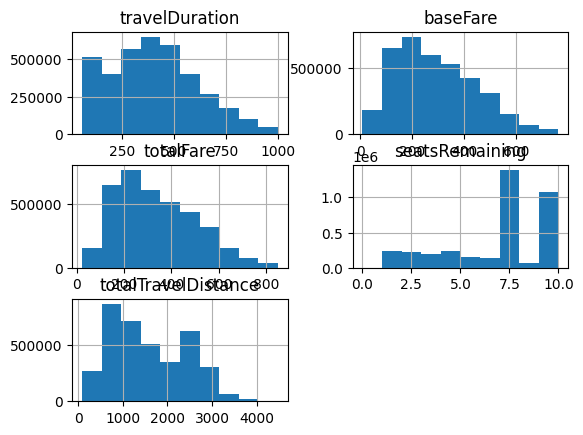

In [12]:
#df = data1.toPandas()
df.boxplot(column=['travelDuration','baseFare','totalFare','totalTravelDistance'])
df.hist(column=['travelDuration','baseFare','totalFare','seatsRemaining','totalTravelDistance'])

#### Корреляции между признаками

In [13]:
data1 = data
data1 = data1.drop('searchDate','flightDate')

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data1.columns, outputCol=vector_col)
df_vector = assembler.transform(data1).select(vector_col)

matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = DataFrame(data=corr_matrix, columns = data1.columns, index=data1.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
startingAirport,1.000000,-0.081853,-0.029075,0.150390,0.148622,-0.027779,0.001613,-0.063808,0.140406,0.142166,-0.009039,0.213991
destinationAirport,-0.081853,1.000000,-0.012197,0.171749,-0.005060,-0.015375,-0.002967,-0.065664,0.116368,0.117690,-0.003208,0.205049
fareBasisCode,-0.029075,-0.012197,1.000000,-0.043434,0.019214,0.153765,0.000996,0.062951,-0.221123,-0.220114,0.037067,-0.069048
travelDuration,0.150390,0.171749,-0.043434,1.000000,0.356456,-0.066384,-0.000868,-0.636909,0.440007,0.458600,-0.077013,0.668732
elapsedDays,0.148622,-0.005060,0.019214,0.356456,1.000000,-0.014680,-0.001377,-0.166178,0.150984,0.157511,-0.000761,0.292434
isBasicEconomy,-0.027779,-0.015375,0.153765,-0.066384,-0.014680,1.000000,-0.001797,0.022205,-0.372613,-0.369799,0.328969,-0.098881
isRefundable,0.001613,-0.002967,0.000996,-0.000868,-0.001377,-0.001797,1.000000,-0.002612,0.021158,0.020712,0.004287,-0.000755
isNonStop,-0.063808,-0.065664,0.062951,-0.636909,-0.166178,0.022205,-0.002612,1.000000,-0.275507,-0.297173,0.085970,-0.384651
baseFare,0.140406,0.116368,-0.221123,0.440007,0.150984,-0.372613,0.021158,-0.275507,1.000000,0.999649,-0.095131,0.486425
totalFare,0.142166,0.117690,-0.220114,0.458600,0.157511,-0.369799,0.020712,-0.297173,0.999649,1.000000,-0.096623,0.493103
